<a href="https://colab.research.google.com/github/Dansah2/Udacity_Tutorials/blob/main/Udacity_CNN_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
# create the necessary methods

def plot_series(time, series, format='', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  """ this is an arbitrary pattern that you can change"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """ repeats the same pattern """
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

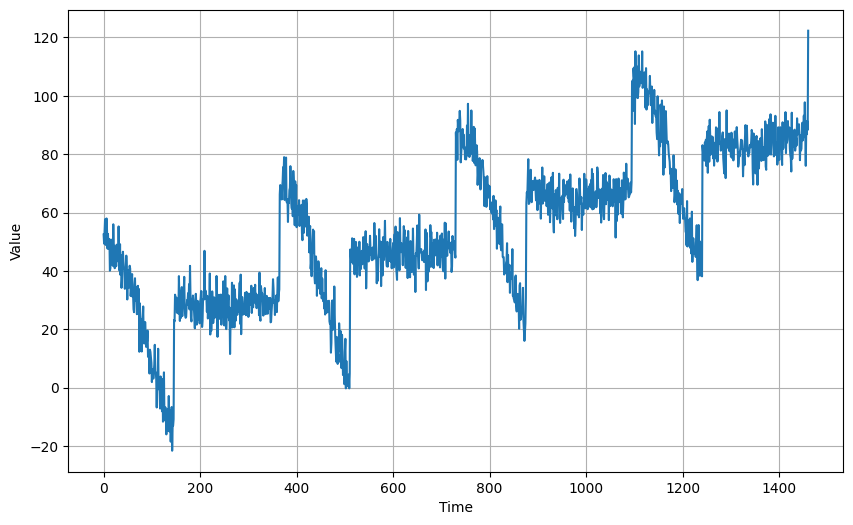

In [3]:
# plot original time series

time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
# split time series
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
# preprocess with 1D convolutional layers
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding='causal',
                        activation='relu', input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 16s 92ms/step - loss: 157.6481 - mae: 158.1480 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 156.5097 - mae: 157.0095 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 154.6244 - mae: 155.1243 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 152.2240 - mae: 152.7239 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 149.3899 - mae: 149.8897 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 146.2604 - mae: 146.7602 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 142.9611 - mae: 143.4609 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 139.6270 - mae: 140.1267 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 136.3072 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

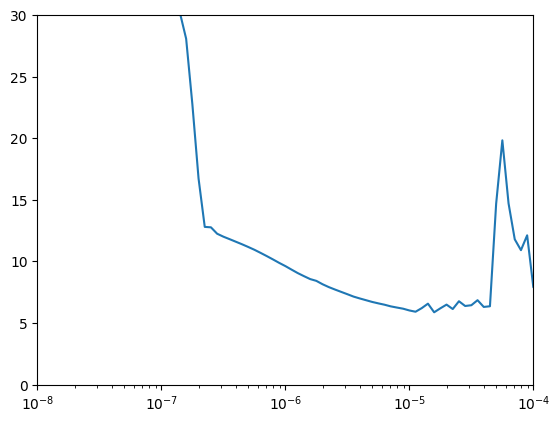

In [6]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding='causal',
                        activation='relu',
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 137ms/step - loss: 18.9645 - mae: 19.4580 - val_loss: 23.4494 - val_mae: 23.9465
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 13.8008 - mae: 14.2923 - val_loss: 19.3821 - val_mae: 19.8779
Epoch 3/500
8/8 [==============================] - 0s 26ms/step - loss: 11.1775 - mae: 11.6657 - val_loss: 15.0319 - val_mae: 15.5224
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 9.6765 - mae: 10.1631 - val_loss: 16.7529 - val_mae: 17.2450
Epoch 5/500
8/8 [==============================] - 0s 25ms/step - loss: 8.6867 - mae: 9.1709 - val_loss: 14.7682 - val_mae: 15.2602
Epoch 6/500
8/8 [==============================] - 0s 28ms/step - loss: 7.9635 - mae: 8.4474 - val_loss: 11.9164 - val_mae: 12.4039
Epoch 7/500
8/8 [==============================] - 0s 25ms/step - loss: 7.5567 - mae: 8.0393 - val_loss: 13.4042 - val_mae: 13.8955
Epoch 8/500
8/8 [==============================] - 0s 36ms/step - lo

In [8]:
model = keras.models.load_model('my_checkpoint.h5')

In [9]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 7ms/step


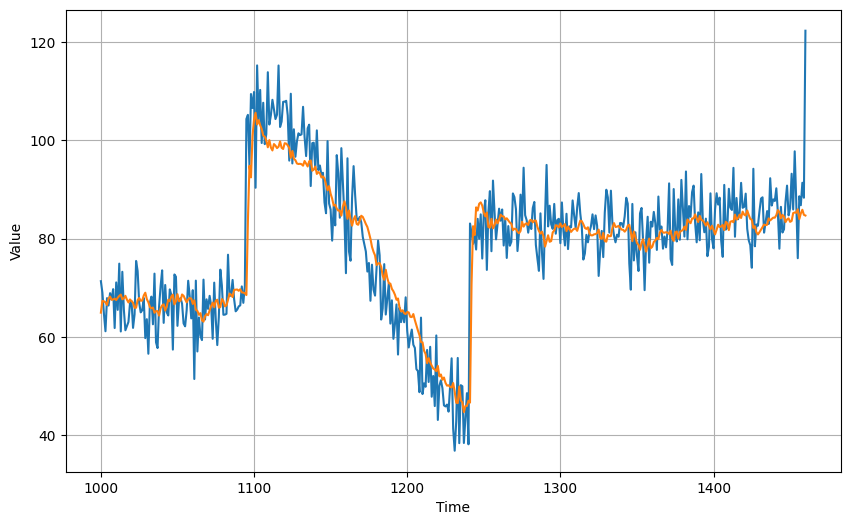

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.9331

In [12]:
# Fully Covolutional Forecasting

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding='causal',
                          activation='relu')
  )
  model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
  lr_schedule = keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-4 * 10**(epoch /30))
  optimizer = keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=['mae'])
  history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 22ms/step - loss: 48.7743 - mae: 49.2737 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 48.5195 - mae: 49.0188 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 48.2457 - mae: 48.7450 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 47.9475 - mae: 48.4467 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 47.6239 - mae: 48.1230 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 47.2724 - mae: 47.7714 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 46.8857 - mae: 47.3847 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 46.4727 - mae: 46.9716 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 46.0171 - mae: 46.5160 - lr: 1.8478e-04


(0.0001, 0.1, 0.0, 30.0)

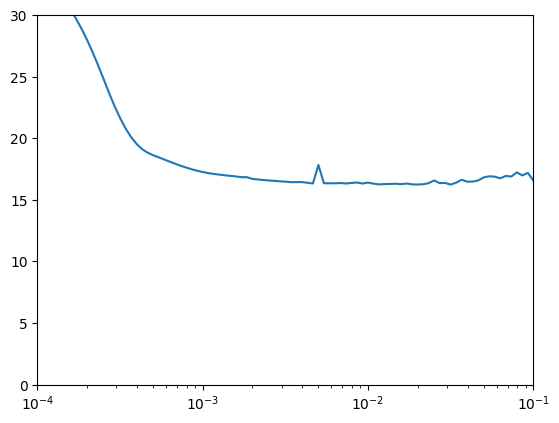

In [14]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding='causal',
                          activation='relu')
  )
  model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
  optimizer = keras.optimizers.Adam(learning_rate=3e-4)
  model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=['mae'])

  model_checkpoint = keras.callbacks.ModelCheckpoint(
      'my_checkpoint.h5', save_best_only=True)
  early_stopping = keras.callbacks.EarlyStopping(patience=50)
  history = model.fit(train_set, epochs=500,
                      validation_data=valid_set,
                      callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 50ms/step - loss: 30.8771 - mae: 31.3755 - val_loss: 56.4030 - val_mae: 56.9030
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 29.7982 - mae: 30.2963 - val_loss: 54.3772 - val_mae: 54.8772
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 28.7208 - mae: 29.2189 - val_loss: 52.3429 - val_mae: 52.8429
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 27.6350 - mae: 28.1334 - val_loss: 50.3176 - val_mae: 50.8176
Epoch 5/500
8/8 [==============================] - 0s 31ms/step - loss: 26.5489 - mae: 27.0476 - val_loss: 48.2901 - val_mae: 48.7901
Epoch 6/500
8/8 [==============================] - 0s 37ms/step - loss: 25.4587 - mae: 25.9569 - val_loss: 46.2350 - val_mae: 46.7350
Epoch 7/500
8/8 [==============================] - 0s 37ms/step - loss: 24.3505 - mae: 24.8484 - val_loss: 44.1884 - val_mae: 44.6884
Epoch 8/500
8/8 [==============================] - 0s 36ms/ste

In [17]:
model = keras.models.load_model('my_checkpoint.h5')

In [19]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 1s 11ms/step


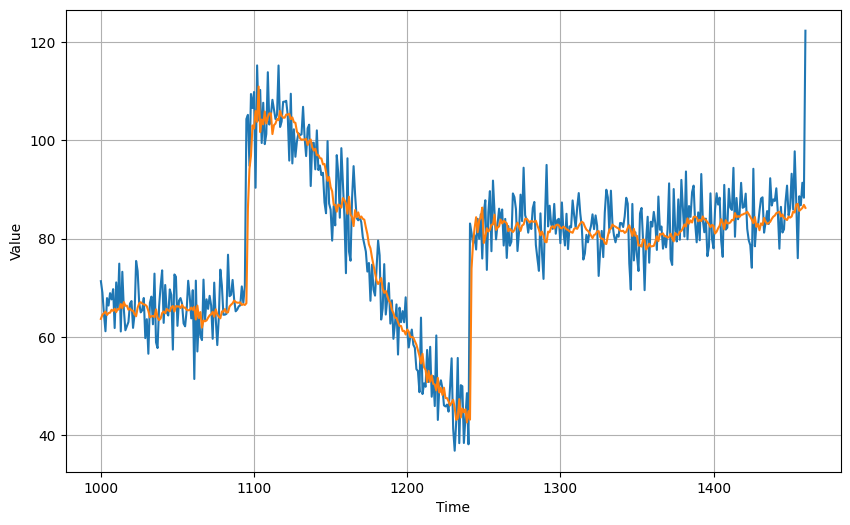

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.577488